# Spring 2019 Statistical NLP, UCSD
Programming Assignment 2: Text Classification <br>


In [86]:
import nltk
import sentiment as sentimentinterface
import classify 
import timeit
import numpy as np
from sklearn.linear_model import LogisticRegression
from scipy.sparse import vstack
from copy import deepcopy
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
%matplotlib inline

## 1. Inspect the Feature representation

In [2]:
print("Reading data")
tarfname = "data/sentiment.tar.gz"
sentiment = sentimentinterface.read_files(tarfname)
    

Reading data
-- train data
sentiment/train.tsv
4582
-- dev data
sentiment/dev.tsv
458
-- transforming data and labels


In [3]:
array = sentiment.trainX # the vocabulary dictionary and return term-document matrix
print(sentiment.train_data[0]) # the first entry in training data
X = sentiment.trainX # term-document matrix; 
# print(X.toarray().shape) #X : array, [n_samples, n_features]
print('~'*50)
print(sentiment.tfidf_vect.inverse_transform(X)[0]) # Return terms with nonzero entries in X[0].
X_arr = X.toarray()
print(X_arr[0], X[0])

Went last night for the first time with my boyfriend. Let me start off by saying I'm vegetarian, but my boyfriend is not. I ordered the chicken v mushroom, it
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
['went' 'last' 'night' 'for' 'the' 'first' 'time' 'with' 'my' 'boyfriend'
 'let' 'me' 'start' 'off' 'by' 'saying' 'vegetarian' 'but' 'is' 'not'
 'ordered' 'chicken' 'mushroom' 'it']
[0. 0. 0. ... 0. 0. 0.]   (0, 9592)	0.15878840323061888
  (0, 4997)	0.18013187210760973
  (0, 5927)	0.18128971329445778
  (0, 3581)	0.09173674343456677
  (0, 8764)	0.11373143876251374
  (0, 3468)	0.16092582463668073
  (0, 8864)	0.1437049999370043
  (0, 9689)	0.11755398468216353
  (0, 5821)	0.1951450431575054
  (0, 1266)	0.5071710508679143
  (0, 5090)	0.21737213645730202
  (0, 5487)	0.14560545620461618
  (0, 8278)	0.2337143151848799
  (0, 6057)	0.19499770394693827
  (0, 1470)	0.1636395674056185
  (0, 7572)	0.24349838833929432
  (0, 9333)	0.2722838762717203
  (0, 1452)	0.11665854303032543
  (0, 4653)	0.

In [4]:
print((sentiment.tfidf_vect.get_feature_names()[6150])) # map id to word
print((sentiment.tfidf_vect.get_feature_names()[1791]))

ordered
chicken


# 2. Inspect the label representation

In [5]:
print('target labels ', sentiment.target_labels)
print('target labels ', sentiment.trainy[:5]) # show the labels of the first 5 training examples
print(list(sentiment.le.classes_))
print(list(sentiment.le.transform(['NEGATIVE', 'POSITIVE'])))
print(list(sentiment.le.inverse_transform(list(sentiment.trainy[:5]))))

target labels  ['NEGATIVE' 'POSITIVE']
target labels  [1 1 0 0 1]
['NEGATIVE', 'POSITIVE']
[0, 1]
['POSITIVE', 'POSITIVE', 'NEGATIVE', 'NEGATIVE', 'POSITIVE']


C:\Users\Ankit Batra\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# 3. Take a look at the data

Went last night for the first time with my boyfriend. Let me start off by saying I'm vegetarian, but my boyfriend is not. I ordered the chicken v mushroom, it


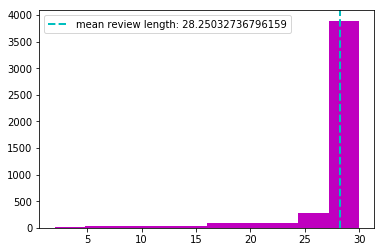

In [6]:
print(sentiment.train_data[0])

lens = []
for review in sentiment.train_data:
    lens.append(len(review.split()))
plt.hist(lens, color='m')
plt.axvline(np.mean(lens), color='c', linestyle='dashed', linewidth=2,label='mean review length: '+str(np.mean(lens)))
plt.legend()
plt.show()

# 4. Train the classifier

In [7]:
cls = classify.train_classifier(sentiment.trainX, sentiment.trainy)
# cls = LogisticRegression(C=10, penalty='l1', random_state=0, max_iter=10000)
# cls.fit(sentiment.trainX, sentiment.trainy)

# 5. What are the decisive features

In [8]:
coefficients=cls.coef_[0]
k = 8
top_k =np.argsort(coefficients)[-k:]
top_k_words = []

print('-'*50)
print('Top k=%d' %k)
print('-'*50)

for i in top_k:
    print(sentiment.tfidf_vect.get_feature_names()[i])
    top_k_words.append(sentiment.tfidf_vect.get_feature_names()[i])
#print(sentiment.count_ve
print('-'*50)
print('Bottom k=%d' %k)
print('-'*50)
#top_k = np.argpartition(coefficients, -k)[-k:]
bottom_k =np.argsort(coefficients)[:k]
bottom_k_words = []
#print(top_k)
for i in bottom_k:
    print(sentiment.tfidf_vect.get_feature_names()[i])
    bottom_k_words.append(sentiment.tfidf_vect.get_feature_names()[i])

#print(sentiment.count_ve

--------------------------------------------------
Top k=8
--------------------------------------------------
friendly
awesome
excellent
delicious
love
best
amazing
great
--------------------------------------------------
Bottom k=8
--------------------------------------------------
not
worst
horrible
terrible
rude
bad
went
disappointed


# 6. How is the classifier doing edge cases

## 6 a) reviews that contain top-k words
 in this case we expect predictions to be mostly POSITIVE (i.e LABEL=1)


  Accuracy on these reviews  is: 0.8091603053435115


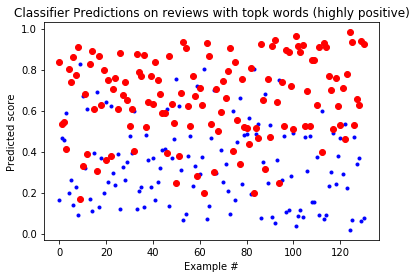

In [9]:
top_k_reviews = []
top_k_labels = []
for j in range(len(sentiment.dev_data)):
    review = sentiment.dev_data[j]
    for word in top_k_words:
        if word in review:
            top_k_reviews.append(review)
            top_k_labels.append(sentiment.dev_labels[j])
            break
    
        #print(review)
dev_X = sentiment.tfidf_vect.transform(top_k_reviews)
classify.evaluate(dev_X, sentiment.le.transform(top_k_labels), cls, 'these reviews')


yp = cls.predict_proba(dev_X) 
#print(yp.shape)
plt.plot(yp[:,0],'b.') # ['0: NEGATIVE', '1:POSITIVE'] 
plt.plot(yp[:,1],'ro') 
plt.title('Classifier Predictions on reviews with topk words (highly positive)')
plt.ylabel('Predicted score')
plt.xlabel('Example #')
plt.show()

## 6b) reviews that contain bottom-k words
 in this case we expect predictions to be mostly NEGATIVE (i.e LABEL=0)

  Accuracy on these reviews  is: 0.8026315789473685


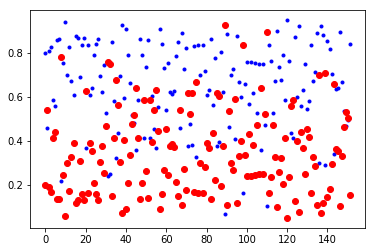

In [10]:
bottom_k_reviews = []
bottom_k_labels = []
for j in range(len(sentiment.dev_data)):
    review = sentiment.dev_data[j]
    for word in bottom_k_words:
        if word in review:
            bottom_k_reviews.append(review)
            bottom_k_labels.append(sentiment.dev_labels[j])
            break
    
        #print(review)
dev_X = sentiment.tfidf_vect.transform(bottom_k_reviews)
classify.evaluate(dev_X, sentiment.le.transform(bottom_k_labels), cls, 'these reviews')
yp = cls.predict_proba(dev_X) 
#print(yp.shape)
plt.plot(yp[:,0],'b.') # ['0: NEGATIVE', '1:POSITIVE'] 
plt.plot(yp[:,1],'ro') 
plt.show()

In [13]:
# Function to read the unlabeled data
def read_unlabeled(tarfname, sentiment):
    """Reads the unlabeled data.

    The returned object contains three fields that represent the unlabeled data.

    data: documents, represented as sequence of words
    fnames: list of filenames, one for each document
    X: bag of word vector for each document, using the sentiment.vectorizer
    """
    import tarfile
    tar = tarfile.open(tarfname, "r:gz")
    class Data: pass
    unlabeled = Data()
    unlabeled.data = []
    
    unlabeledname = "unlabeled.tsv"
    for member in tar.getmembers():
        if 'unlabeled.tsv' in member.name:
            unlabeledname = member.name
            
    print(unlabeledname)
    tf = tar.extractfile(unlabeledname)
    for line in tf:
        line = line.decode("utf-8")
        text = line.strip()
        unlabeled.data.append(text)
        
            
    unlabeled.X = sentiment.tfidf_vect.transform(unlabeled.data)
    print(unlabeled.X.shape)
    tar.close()
    return unlabeled

In [14]:
# Reading the unlabeled data
unlabeled_data = read_unlabeled(tarfname, sentiment)

sentiment/unlabeled.tsv
(91524, 9882)


In [32]:
unlabeled_data.X.shape[0]

91524

In [57]:
# Amount of unlabeled data to be used 
amt_unlabeled = np.arange(0, 1.1, 0.1)

In [74]:
# labeled_data = sentiment.trainX
# labels = sentiment.trainy
# for amount in amt_unlabeled:
#     unlabel_data = unlabeled_data.X[:int(amount*unlabeled_data.X.shape[0])]
#     tot_data = vstack([labeled_data, unlabeled_data.X[:int(amount*unlabeled_data.X.shape[0])]])
#     for i in range(100):
#         cls = classify.train_classifier(tot_data, labels)

In [92]:
def read_files(tarfname):
    """Read the training and development data from the sentiment tar file.
    The returned object contains various fields that store sentiment data, such as:

    train_data,dev_data: array of documents (array of words)
    train_fnames,dev_fnames: list of filenames of the doccuments (same length as data)
    train_labels,dev_labels: the true string label for each document (same length as data)

    The data is also preprocessed for use with scikit-learn, as:

    count_vec: CountVectorizer used to process the data (for reapplication on new data)
    trainX,devX: array of vectors representing Bags of Words, i.e. documents processed through the vectorizer
    le: LabelEncoder, i.e. a mapper from string labels to ints (stored for reapplication)
    target_labels: List of labels (same order as used in le)
    trainy,devy: array of int labels, one for each document
    """
    import tarfile
    tar = tarfile.open(tarfname, "r:gz")
    trainname = "train.tsv"
    devname = "dev.tsv"
    for member in tar.getmembers():
        if 'train.tsv' in member.name:
            trainname = member.name
        elif 'dev.tsv' in member.name:
            devname = member.name
            
            
    class Data: pass
    sentiment = Data()
    print("-- train data")
    sentiment.train_data, sentiment.train_labels = read_tsv(tar,trainname)
    print(len(sentiment.train_data))

    print("-- dev data")
    sentiment.dev_data, sentiment.dev_labels = read_tsv(tar, devname)
    print(len(sentiment.dev_data))
    print("-- transforming data and labels")
    from sklearn.feature_extraction.text import TfidfVectorizer
    sentiment.tfidf_vect = TfidfVectorizer()
    sentiment.trainX = sentiment.tfidf_vect.fit_transform(sentiment.train_data)
    sentiment.devX = sentiment.tfidf_vect.transform(sentiment.dev_data)
    from sklearn import preprocessing
    sentiment.le = preprocessing.LabelEncoder()
    sentiment.le.fit(sentiment.train_labels)
    sentiment.target_labels = sentiment.le.classes_
    sentiment.trainy = sentiment.le.transform(sentiment.train_labels)
    sentiment.devy = sentiment.le.transform(sentiment.dev_labels)
    tar.close()
    return sentiment

In [93]:
def read_tsv(tar, fname):
    member = tar.getmember(fname)
    print(member.name)
    tf = tar.extractfile(member)
    data = []
    labels = []
    for line in tf:
        line = line.decode("utf-8")
        (label,text) = line.strip().split("\t")
        labels.append(label)
        data.append(text)
    return data, labels

In [95]:
print("Reading data")
tarfname = "data/sentiment.tar.gz"
sentiment = read_files(tarfname)
print("\nTraining classifier")
import classify
cls = classify.train_classifier(sentiment.trainX, sentiment.trainy)
print("\nEvaluating")
classify.evaluate(sentiment.trainX, sentiment.trainy, cls, 'train')
classify.evaluate(sentiment.devX, sentiment.devy, cls, 'dev')

print("\nReading unlabeled data")
unlabeled = read_unlabeled(tarfname, sentiment)
updated_trainy = deepcopy(sentiment.trainy)
updated_train_data = deepcopy(sentiment.train_data)
unlabeledX = np.array(unlabeled.data)
updated_trainy = np.array(updated_trainy)
updated_train_data = np.array(updated_train_data)
for i in range(100):
    unlabeled.X = sentiment.tfidf_vect.transform(unlabeledX)
    #unlabeled.X = sentiment.tfidf_transform.transform(unlabeled.X)
    y_prob = np.array(cls.predict_proba(unlabeled.X))
    y_unlabeled = np.array(cls.predict(unlabeled.X))
    confident_indices = np.argwhere(y_prob>=0.9)
    print(i, len(confident_indices), unlabeledX.shape)
    chosen_indices = confident_indices[:,0][np.random.choice(len(confident_indices), size=len(confident_indices)//4, replace=False)]
    updated_trainy = np.concatenate([updated_trainy, y_unlabeled[chosen_indices]])
    updated_train_data = np.concatenate([updated_train_data , unlabeledX[chosen_indices]])
    updated_trainx = sentiment.tfidf_vect.transform(updated_train_data)
    #updated_trainx = sentiment.tfidf_transform.transform(updated_trainx)
    cls = classify.train_classifier(updated_trainx, updated_trainy)
    unlabeledX = np.delete(unlabeledX, chosen_indices)
    classify.evaluate(sentiment.devX, sentiment.devy, cls, 'dev')

Reading data
-- train data
sentiment/train.tsv
4582
-- dev data
sentiment/dev.tsv
458
-- transforming data and labels

Training classifier

Evaluating
  Accuracy on train  is: 0.9020078568310781
  Accuracy on dev  is: 0.7663755458515283

Reading unlabeled data
sentiment/unlabeled.tsv
(91524, 9882)
0 21207 (91524,)
  Accuracy on dev  is: 0.7641921397379913
1 33127 (86223,)
  Accuracy on dev  is: 0.75764192139738
2 35821 (77942,)
  Accuracy on dev  is: 0.7445414847161572
3 33180 (68987,)
  Accuracy on dev  is: 0.7489082969432315
4 28764 (60692,)
  Accuracy on dev  is: 0.7467248908296943
5 24219 (53501,)
  Accuracy on dev  is: 0.7467248908296943
6 20105 (47447,)
  Accuracy on dev  is: 0.7445414847161572
7 16505 (42421,)
  Accuracy on dev  is: 0.7467248908296943
8 13387 (38295,)
  Accuracy on dev  is: 0.7445414847161572
9 10897 (34949,)
  Accuracy on dev  is: 0.7445414847161572


In [98]:
def write_pred_kaggle_file(unlabeled, cls, outfname, sentiment):
    """Writes the predictions in Kaggle format.

    Given the unlabeled object, classifier, outputfilename, and the sentiment object,
    this function write sthe predictions of the classifier on the unlabeled data and
    writes it to the outputfilename. The sentiment object is required to ensure
    consistent label names.
    """
    yp = cls.predict(unlabeled.X)
    labels = sentiment.le.inverse_transform(yp)
    f = open(outfname, 'w')
    f.write("ID,LABEL\n")
    for i in range(len(unlabeled.data)):
        f.write(str(i+1))
        f.write(",")
        f.write(labels[i])
        f.write("\n")
    f.close()

In [99]:
print("\nReading unlabeled data")
unlabeled = read_unlabeled(tarfname, sentiment)
print("Writing predictions to a file")
write_pred_kaggle_file(unlabeled, cls, "data/unsup-sentiment-pred.csv", sentiment)


Reading unlabeled data
sentiment/unlabeled.tsv
(91524, 9882)
Writing predictions to a file


C:\Users\Ankit Batra\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
